In [1]:
#!pip install --upgrade lightgbm xgboost catboost

In [1]:
import lightgbm as lgb, xgboost as xgb, catboost as cb

for lib in [lgb, xgb, cb]:
    print(lib.__name__, lib.__version__)

lightgbm 4.3.0
xgboost 2.0.3
catboost 1.2.3


In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## CPU: i5 12600K, GPU: 3060ti

In [3]:
from local_manipulations import *

data = read_data()
for col in data.loc[:, data.dtypes == object].columns:
    data[col] = data[col].astype('category').cat.codes.astype('category') # для catboost
    
X_tr, y_tr, X_val, y_val = split_data(data) # train / val / test
data.head(3)

tst shape: (61502, 122)
val shape: (73802, 122)
tr shape: (172207, 122)


sk_id_curr  target name_contract_type code_gender flag_own_car  \
0      100002       1                  0           1            0   
1      100003       0                  0           0            0   
2      100004       0                  1           1            1   

  flag_own_realty  cnt_children  amt_income_total  amt_credit  amt_annuity  \
0               1             0          202500.0    406597.5      24700.5   
1               0             0          270000.0   1293502.5      35698.5   
2               1             0           67500.0    135000.0       6750.0   

   ...  flag_document_18 flag_document_19 flag_document_20 flag_document_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   

  amt_req_credit_bureau_hour amt_req_credit_bureau_day  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   

   amt_req_credit_bureau_week  amt_req_credit_bureau_mon  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   

   amt_req_credit_bureau_qrt  amt_req_credit_bureau_year  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  

[3 rows x 122 columns]

## 1. XGBoost vs. LightGBM

CPU times: total: 13min 1s
Wall time: 2min 10s


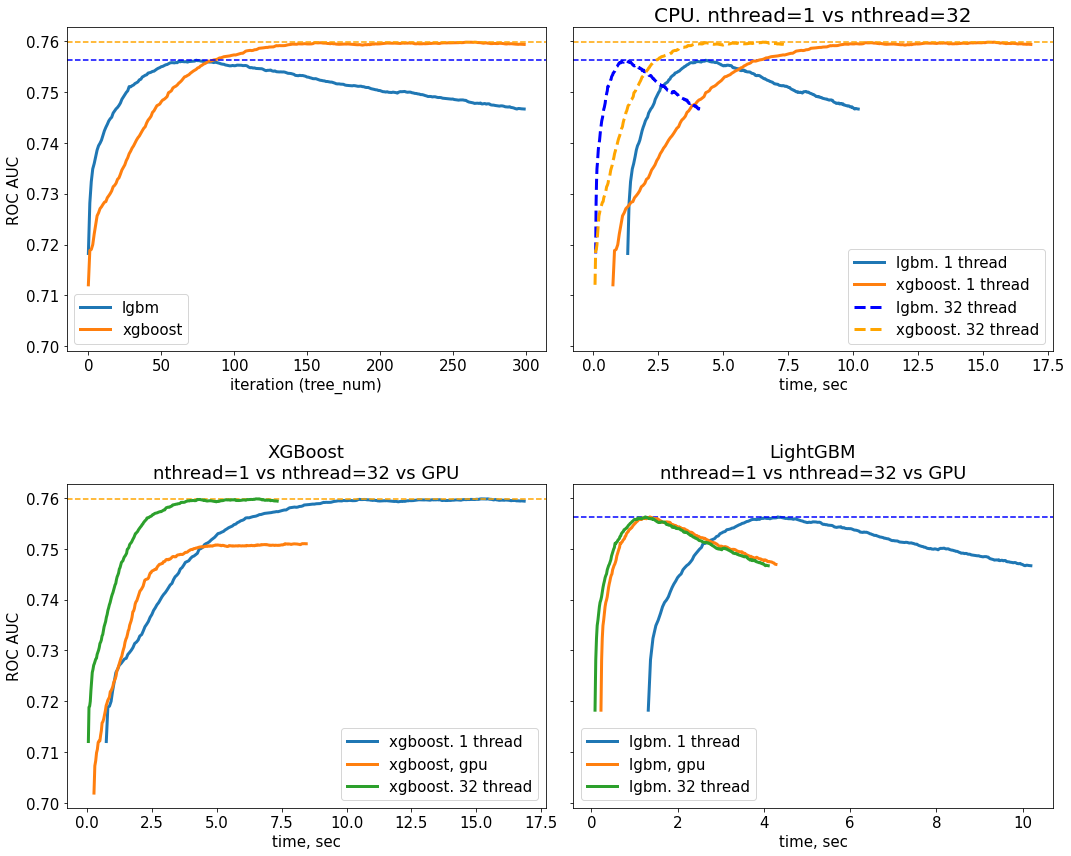

In [5]:
%%time

res_lgb_plain, res_lgb_sklearn = plot_xgb_lgb_results(
    X_tr=X_tr, y_tr=y_tr,
    X_val=X_val, y_val=y_val,
    n_trials=40
)

***LightGBM (в сравнении с XGBoost)***

  Плюсы:
- быстрее строит деревья
- лучше параллелится на CPU
- GPU сходится к тому же качеству, что и CPU
- имеет много чего поверх функционала xgboost (параметры, фишки, режимы)
- сурс код

<br> Минусы:
- пока нет нормального API для настройки кастомных коллбэков (но можно разобраться с помощью сурс кода)

***Вывод: забываем про XGBoost***

## 2. LightGBM

### `2.0 sklearn API`

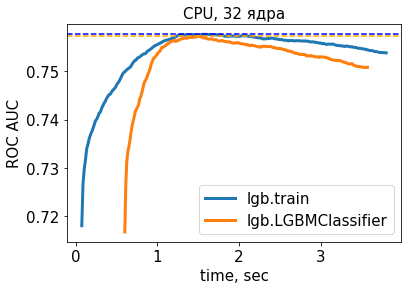

In [5]:
from local_manipulations import *

plot_lgb_sklearn_results(
    res_lgb_plain, res_lgb_sklearn
)

***Вывод: забываем про sklearn API***

### `2.1 Training API`

- sample code
- early stopping
- lgb.Dataset
- lgb.train
- lgb.Booster
    - predict
- lgb.cv

In [6]:
X_tr.head(2)

name_contract_type code_gender flag_own_car flag_own_realty  cnt_children  \
0                  0           1            0               1             0   
1                  0           0            0               0             0   

   amt_income_total  amt_credit  amt_annuity  amt_goods_price name_type_suite  \
0          202500.0    406597.5      24700.5         351000.0               6   
1          270000.0   1293502.5      35698.5        1129500.0               1   

   ... flag_document_18 flag_document_19 flag_document_20 flag_document_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   

   amt_req_credit_bureau_hour  amt_req_credit_bureau_day  \
0                         0.0                        0.0   
1                         0.0                        0.0   

   amt_req_credit_bureau_week  amt_req_credit_bureau_mon  \
0                         0.0                        0.0   
1                         0.0                        0.0   

   amt_req_credit_bureau_qrt  amt_req_credit_bureau_year  
0                        0.0                         1.0  
1                        0.0                         0.0  

[2 rows x 120 columns]

**sample code.**

In [7]:
lgb_tr = lgb.Dataset(X_tr, label=y_tr, free_raw_data=False)

params = {
    'objective': 'binary', # or custom callable
    'eta': 0.1,
    'lambda': 1e-3,
    
    'seed': 911,
    'num_threads': 32,
    'verbosity': 1
}

model = lgb.train(
    params, lgb_tr, num_boost_round=10, # basic
)

[LightGBM] [Info] Number of positive: 13978, number of negative: 158229
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11399
[LightGBM] [Info] Number of data points in the train set: 172207, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081170 -> initscore=-2.426559
[LightGBM] [Info] Start training from score -2.426559


**early stopping.**

In [8]:
lgb_val = lgb.Dataset(X_val, label=y_val, free_raw_data=False)

params.update({
    'metric': ['auc', ''], # '' = objective; 'None' = off
})
my_custom_metrics = None

model = lgb.train(
    params, lgb_tr, num_boost_round=20, # basic
    valid_sets=[lgb_val], valid_names=['валидация'],
    feval=my_custom_metrics, # можно задать кастомные метрики для early_stopping
    callbacks=[
        lgb.early_stopping(stopping_rounds=3, min_delta=0.),
        lgb.log_evaluation(period=3) # чтобы выводились результаты подсчета метрики для early_stopping
   ] 
)

[LightGBM] [Info] Number of positive: 13978, number of negative: 158229
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11399
[LightGBM] [Info] Number of data points in the train set: 172207, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081170 -> initscore=-2.426559
[LightGBM] [Info] Start training from score -2.426559
Training until validation scores don't improve for 3 rounds
[3]	валидация's auc: 0.723544
[6]	валидация's auc: 0.730646
[9]	валидация's auc: 0.73345
[12]	валидация's auc: 0.736762
[15]	валидация's auc: 0.740328
[18]	валидация's auc: 0.742572
Did not meet early stopping. Best iteration is:
[20]	валидация's auc: 0.744853


**lgb.Dataset**

In [9]:
lgb_tr = lgb.Dataset(
    X_tr, label=y_tr, free_raw_data=False, # basic
    weight=None # веса на объектах
)

%time lgb_tr.construct() # инициализировать биннинг и прочие подготовительные моменты (иначе делается в вызове lgb.train)

CPU times: total: 2.47 s
Wall time: 356 ms


**lgb.Booster**

In [10]:
print('model:', model)

print('\npredict:', model.predict(X_val)[:5])
print('raw predict:', model.predict(X_val, raw_score=True)[:5])
print('pred leaf:', model.predict(X_val, pred_leaf=True)[:5])

model: <lightgbm.basic.Booster object at 0x00000237862D2E30>

predict: [0.07182898 0.13998338 0.04029374 0.14729319 0.03158576]
raw predict: [-2.55892799 -1.81542798 -3.17043121 -1.75599067 -3.42295362]
pred leaf: [[ 8  7  8 19 14 28 11  6  9 30  3 10 18 15  3 18 20  5 22 24]
 [ 4 12 28 11 11 15 14  7 20 22  1  0 23 20 16 13 20 19 20 29]
 [30 20 17 10 12 20 13 20 15  5 14  6  4  7 22 23 29 12 19 12]
 [10  6 24 25 25 18 26 15 17 12 11 28 12 13 25 13 14 11 11 19]
 [30 20  3 10  3 20  8 20 15  5  5  6  4 29 27  6  7  8 13  1]]


**lgb.cv**

In [11]:
from sklearn.model_selection import KFold

params['verbosity'] = 0
lgb.cv(
    params, lgb_tr, num_boost_round=10,
    nfold=5, stratified=True, shuffle=True, seed=911
)

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081167 -> initscore=-2.426593
[LightGBM] [Info] Start training from score -2.426593
[LightGBM] [Warning] Detected that num_threads changed during training (from 32 to 16), it may cause unexpected errors.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081167 -> initscore=-2.426593
[LightGBM] [Info] Start training from score -2.426593
[LightGBM] [Warning] Detected that num_threads changed during training (from 32 to 16), it may cause unexpected errors.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081167 -> initscore=-2.426601
[LightGBM] [Info] Start training from score -2.426601
[LightGBM] [Warning] Detected that num_threads changed during training (from 32 to 16), it may cause unexpected errors.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081174 -> initscore=-2.426503
[LightGBM] [Info] Start training from score -2.426503
[LightGBM] [Warning] Detected that num_threads changed during training (from 32 to 16), it may cause une

{'valid auc-mean': [0.7038558172400343,
  0.712814301538139,
  0.7182188272485746,
  0.720137694082578,
  0.722267888591686,
  0.7237972753782248,
  0.7248784160585432,
  0.7259919735140756,
  0.7272211413293965,
  0.728362325284247],
 'valid auc-stdv': [0.0026888629221909458,
  0.0019142384710145943,
  0.002415796647582921,
  0.002557383400419143,
  0.0023955458689075173,
  0.002025520764375536,
  0.0023704699456204635,
  0.0024393899720865707,
  0.0027640348538185105,
  0.002737860906125391]}

### `2.2 Parameters`

- eta
- lambda, min_sum_hessian_in_leaf
- quantization settings
- online-регуляризация дерева - min_data_in_leaf, max_depth, max_leaves
- sampling strategies
- categories
- EFB
- monotonic_constraints


<br><br>
**1. `eta` - база**

In [12]:
%%time
from local_manipulations import *

param_info = {
    'eta': (1e-3, 1, 'float'),
    'nthread': 16
}
study = start_lgb_random_search(param_info, n_trials=40, X_tr=X_tr, y_tr=y_tr, X_val=X_val, y_val=y_val)

CPU times: total: 9min 34s
Wall time: 39 s


In [13]:
from optuna.visualization import plot_slice

fig = plot_slice(study, target=lambda trial: trial.values[0], target_name='ROC AUC score')
fig.update_layout(height=400, width=600)

In [14]:
fig = plot_slice(study, target=lambda trial: trial.values[1], target_name='time')
fig.update_layout(height=400, width=600)

**2. `lambda`, `min_sum_hessian_in_leaf` - альтернативное влияние на величину весов**

In [15]:
%%time
from local_manipulations import *

param_info = {
    'eta': 0.02,
    'lambda': (1e-4, 10000, 'float'),
    'min_sum_hessian_in_leaf': (1e-3, 100, 'float'),
    
    'nthread': 16
}
study = start_lgb_random_search(param_info, n_trials=100, X_tr=X_tr, y_tr=y_tr, X_val=X_val, y_val=y_val)

fig = plot_slice(study, target=lambda trial: trial.values[0], target_name='ROC AUC score')
fig.update_layout(height=400, width=600)

CPU times: total: 28min 41s
Wall time: 1min 58s


In [16]:
fig = plot_slice(study, target=lambda trial: trial.values[1], target_name='time')
fig.update_layout(height=400, width=600)

In [17]:
from optuna.visualization import plot_contour

fig = plot_contour(study, target=lambda trial: max(0.7, trial.values[0]), target_name='auc')
fig.update_layout(height=500, width=700)

In [18]:
fig = plot_contour(study, target=lambda trial: max(0.7, trial.values[1]), target_name='time, sec')
fig.update_layout(height=500, width=700)

**3. quantization settings**

In [19]:
{
    'max_bin': 254, # ставьте степень двойки - 2
    'max_bin_by_feature': None,
    'min_data_in_bin': 100,
    'bin_construct_sample_cnt': 200_000,
    'zero_as_missing': True # 0 и nan считаются за missing
}

{'max_bin': 254,
 'max_bin_by_feature': None,
 'min_data_in_bin': 100,
 'bin_construct_sample_cnt': 200000,
 'zero_as_missing': True}

Настраивайте только если вы "что-то знаете" или "что-то хотите"... :)

**4. `min_data_in_leaf`, `max_depth`, `max_leaves` - online-регуляризация дерева**

In [20]:
%%time
from local_manipulations import *

param_info = {
    'eta': 0.02,
    'lambda': 0.15,
    'min_sum_hessian_in_leaf': 2.5, # ~min_data_in_leaf (ПРИМЕРНО)
    
    'min_data_in_leaf': (1, 500, 'int'),
    'max_leaves': (10, 80, 'int'),
    'max_depth': -1, # Не надо это использовать для lossguide-деревьев
    
    'nthread': 16
}
study = start_lgb_random_search(param_info, n_trials=100, X_tr=X_tr, y_tr=y_tr, X_val=X_val, y_val=y_val)

fig = plot_slice(study, target=lambda trial: trial.values[0], target_name='ROC AUC score')
fig.update_layout(height=400, width=600)

CPU times: total: 29min 43s
Wall time: 1min 58s


In [21]:
fig = plot_slice(study, target=lambda trial: trial.values[1], target_name='time')
fig.update_layout(height=400, width=600)

**5. categories**

**`max_cat_to_onehot` - база**

In [22]:
%%time
from local_manipulations import *

param_info = {
    'eta': 0.02,
    'lambda': 0.15,
    'min_sum_hessian_in_leaf': 2.5,
    'min_data_in_leaf': 3,
    'max_leaves': 28,
    'max_depth': -1,
    
    'max_cat_to_onehot': (2, 6, 'int'),
#     'max_cat_threshold'  # ~ max_bin для категорий
#     'min_data_per_group'
#     'cat_l2'
#     'cat_smooth'
    
    'nthread': 16
}
study = start_lgb_random_search(param_info, n_trials=23, X_tr=X_tr, y_tr=y_tr, X_val=X_val, y_val=y_val)

fig = plot_slice(study, target=lambda trial: trial.values[0], target_name='ROC AUC score')
fig.update_layout(height=400, width=600)

CPU times: total: 7min 3s
Wall time: 28.7 s


In [23]:
fig = plot_slice(study, target=lambda trial: trial.values[1], target_name='time')
fig.update_layout(height=400, width=600)

**остальное - уже после**

In [24]:
%%time
from local_manipulations import *

param_info = {
    'eta': 0.02,
    'lambda': 0.15,
    'min_sum_hessian_in_leaf': 2.5,
    'min_data_in_leaf': 3,
    'max_leaves': 28,
    'max_depth': -1,
    
    'max_cat_to_onehot': 3,
    'max_cat_threshold': (2, 64, 'int'),  # ~ max_bin для категорий
    'min_data_per_group': (1, 100, 'int'),
#     'cat_l2'
#     'cat_smooth'
    
    'nthread': 16
}
study = start_lgb_random_search(param_info, n_trials=200, X_tr=X_tr, y_tr=y_tr, X_val=X_val, y_val=y_val)

fig = plot_slice(study, target=lambda trial: trial.values[0], target_name='ROC AUC score')
fig.update_layout(height=400, width=600)

CPU times: total: 58min 29s
Wall time: 3min 52s


In [25]:
fig = plot_contour(study, target=lambda trial: trial.values[0])
fig.update_layout(height=500, width=700)

**Так как мы подбирали все зафиксированные параметры исходя из дефолтных значений остальных, мы переобучились под дефолт :(**

Уберем теперь полученные до этого параметры и поищем еще...

In [26]:
%%time
from local_manipulations import *

param_info = {
    'max_cat_to_onehot': 5,
    'max_cat_threshold': (2, 64, 'int'),  # ~ max_bin для категорий
    'min_data_per_group': (1, 100, 'int'),
#     'cat_l2'
#     'cat_smooth'
    
    'nthread': 16
}
study = start_lgb_random_search(param_info, n_trials=200, X_tr=X_tr, y_tr=y_tr, X_val=X_val, y_val=y_val)

fig = plot_slice(study, target=lambda trial: trial.values[0], target_name='ROC AUC score')
fig.update_layout(height=400, width=600)

CPU times: total: 49min 38s
Wall time: 3min 20s


In [27]:
fig = plot_contour(study, target=lambda trial: trial.values[0])
fig.update_layout(height=500, width=700)

Это уже другая картина и намного более адекватная)

**Вывод: перебирайте только те гиперпараметры, которые вам реально НУЖНО изменить. Не перебирайте все подряд!**

**6.**

**`EFB` - Efficient Feature Bundling**

**`monotone_constraints` - если вам нужно настроить связи вида "чем больше эта фича, тем больше должен быть таргет"**

**7. sampling strategies: `None` vs. `subsample` vs. `GOSS`**

In [28]:
X_dummy = np.random.randn(3_000_000, 500).astype(np.float32)
y_dummy = ((X_dummy[:, 0] + X_dummy[:, 1]) < 0).astype(np.uint8)

In [29]:
%%time
from local_manipulations import start_lgb_subsample_search

# GOSS
params = {
        'data_sample_strategy': 'goss',
        'top_rate': 0.2,
        'other_rate': 0.1,

        'nthread': 16,
        'verbosity': -1,
        'eta': 1 # internally, LightGBM uses gbdt mode for the first 1 / learning_rate iterations
    }

study_goss = start_lgb_subsample_search(params, X_dummy, y_dummy)

# subsample
params = {
        'data_sample_strategy': 'bagging',
        'bagging_freq': 1,
        'bagging_fraction': 0.1,

        'nthread': 16,
        'verbosity': -1,
        'eta': 1
    }

study_subsample = start_lgb_subsample_search(params, X_dummy, y_dummy)

CPU times: total: 32min 17s
Wall time: 2min 23s


**`GOSS`**

In [30]:
fig = plot_slice(study_goss)
fig.update_layout(height=400)

**`subsample`**

In [31]:
fig = plot_slice(study_subsample)
fig.update_layout(height=400)

**Вывод: subsample вполне можно использовать, а вот с GOSS нужно перепроверять скорость и качество + он зависит от eta!**

### `2.3 quantized_grad`

[статья](https://arxiv.org/abs/2207.09682)

Пока не работает! (пробовал даже на версии 4.0.0, когда только вышло)

Убивает ядро просто при попытке обучиться с остальными параметрами из коробки...

In [ ]:
# %%time
# from local_manipulations import *

# param_info = {
#     'use_quantized_grad': [True, False],
#     'num_grad_quant_bins': 4,
#     'quant_train_renew_leaf ': False,
#     'stochastic_rounding': False,
#     'nthread': 1
# }
# study = start_lgb_random_search(param_info, n_trials=4, X_tr=X_tr, y_tr=y_tr, X_val=X_val, y_val=y_val)

# fig = plot_slice(study, target=lambda trial: trial.values[0], target_name='ROC AUC score')
# fig.update_layout(height=400, width=600)

### `2.4 GBDT-PL`

[статья](https://arxiv.org/pdf/1802.05640.pdf)<br>
[докладик](https://youtu.be/lxTrWYyzT9s?si=G2xnWQTpjB5XkPv_&t=3520)

In [6]:
%%time
from local_manipulations import *

param_info = {
    'linear_tree': [True, False],
    
    'nthread': 16
}
study = start_lgb_random_search(param_info, n_trials=13, X_tr=X_tr, y_tr=y_tr, X_val=X_val, y_val=y_val)

from optuna.visualization import *

fig = plot_slice(study, target=lambda trial: trial.values[0], target_name='ROC AUC score')
fig.update_layout(height=400, width=600)

CPU times: total: 3min 12s
Wall time: 13.4 s


In [7]:
fig = plot_slice(study, target=lambda trial: trial.values[1], target_name='time, sec')
fig.update_layout(height=400, width=600)

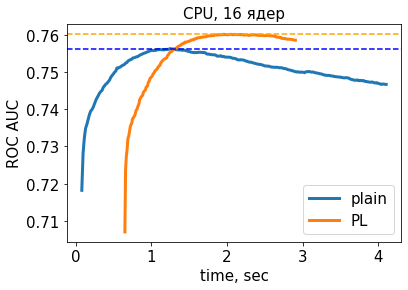

In [8]:
from local_manipulations import *

plot_lgb_gbdtpl_results(res_lgb_plain, X_tr, y_tr, X_val, y_val)

### `2.5 DART`

... на следующем семинаре!

### `2.6 custom callbacks`

In [14]:
# из сурс кода:

# Callback environment used by callbacks
'''
@dataclass
class CallbackEnv:
    model: Union[Booster, "CVBooster"]
    params: Dict[str, Any]
    iteration: int
    begin_iteration: int
    end_iteration: int
    evaluation_result_list: Optional[_ListOfEvalResultTuples]
'''
        
# 1 - simple
def custom_callback(*args, **kwargs):
    # before all iterations
    
    def custom_callable(env, *args, **kwargs):
        # do smth after every iteration
        pass
    
    return custom_callable


# 2 - advanced
class CustomCallback:
    def __init__(self, *args, **kwargs):
        # before all iterations
        pass
    
    def __call__(self, env, *args, **kwargs):
        # do smth after every iteration
        pass
    
def custom_callback(*args, **kwargs):
    # before all iterations
    return CustomCallback(*args, **kwargs)

### `2.7 Интерпретация`

... на следующих семинарах!

## 3. CatBoost

[туториалы](https://github.com/catboost/tutorials/)

### `3.0 sklearn API`

Не рассматриваем примерно по тем же причинам

### `3.1 CatBoost class API`
- sample code
- early stopping
- cb.Pool
- cb.CatBoost
    - fit vs cb.train
    - predict
- cb.cv


**sample code**

In [32]:
cat_features = data.columns[data.dtypes == 'category'].tolist()

pool_tr = cb.Pool(X_tr, y_tr, cat_features=cat_features)

params = {
    'objective': 'Logloss',
    'learning_rate': 0.1,
    'iterations': 10,
    
    'verbose': False,
    'random_seed': 911
}
model = cb.CatBoost(params)
model.fit(pool_tr)

model.predict(pool_tr)

array([-1.23175293, -1.75501198, -1.48370654, ..., -1.03551447,
       -1.73329521, -1.81415377])

**early stopping**

In [33]:
params.update({
    'early_stopping_rounds': 2,
    'od_type': 'Iter',
    
    'verbose': True
})

model = cb.CatBoost(params)
model.fit(pool_tr)

0:	learn: 0.5929258	total: 84.3ms	remaining: 759ms
1:	learn: 0.5171063	total: 173ms	remaining: 691ms
2:	learn: 0.4622251	total: 286ms	remaining: 668ms
3:	learn: 0.4166708	total: 397ms	remaining: 595ms
4:	learn: 0.3825292	total: 497ms	remaining: 497ms
5:	learn: 0.3559271	total: 596ms	remaining: 397ms
6:	learn: 0.3366231	total: 688ms	remaining: 295ms
7:	learn: 0.3200156	total: 778ms	remaining: 195ms
8:	learn: 0.3080066	total: 865ms	remaining: 96.1ms
9:	learn: 0.2976517	total: 953ms	remaining: 0us


**cb.Pool**

In [34]:
'''
class Pool(
    data,
    label=None,
    cat_features=None,
    text_features=None,
    embedding_features=None,
    weight=None,
    baseline=None,
    timestamp=None,
    ...
)
'''

pool_tr = cb.Pool(X_tr, y_tr, cat_features=cat_features)

%time pool_tr.quantize()

CPU times: total: 1.09 s
Wall time: 111 ms


**cb.CatBoost**
- calc_feature_statistics
- calc_leaf_indexes
- predict
    - prediction_type
- fit or cb.train?

**cb.cv**

Тоже существует :)

### `3.2 Parameters`
- eta, lambda, depth
- quantization settings
- sampling strategies
- score functions
- leaf_estimation_method + iterations
- monotone_constraints


<br><br>
**1. `eta` - база. `lambda`, `depth` - аналогично lgbm / настраивайте сами**

In [35]:
%%time

from local_manipulations import *

params = {
    'eta': (1e-3, 1, 'float'),
    'thread_count': 16
}

study = start_cb_random_search(params, X_tr, y_tr, X_val, y_val, n_trials=100, cat_features=cat_features)

fig = plot_slice(study, target=lambda trial: trial.values[0], target_name='ROC AUC score')
fig.update_layout(height=400, width=600)

CPU times: total: 48min 44s
Wall time: 8min 34s


In [36]:
fig = plot_slice(study, target=lambda trial: trial.values[1], target_name='time, sec')
fig.update_layout(height=400, width=600)

**2. quantization settings**

[дока](https://catboost.ai/en/docs/references/training-parameters/quantization)

In [37]:
{
    'border_count': 254, # ставьте степень двойки - 2
    'target_border': None,
    'feature_border_type': 'GreedyLogSum',
    'per_float_feature_quantization': ['0:border_count=1024', '1:border_count=126'] # :)
}

{'border_count': 254,
 'target_border': None,
 'feature_border_type': 'GreedyLogSum',
 'per_float_feature_quantization': ['0:border_count=1024',
  '1:border_count=126']}

**4. score functions**

In [38]:
params = {
    'eta': 0.2,
    'thread_count': 1,
    
    'score_function': ['Cosine', 'L2']
}

study = start_cb_random_search(params, X_tr, y_tr, X_val, y_val, n_trials=13, cat_features=cat_features)

fig = plot_slice(study, target=lambda trial: trial.values[0], target_name='ROC AUC score')
fig.update_layout(height=400, width=600)

In [39]:
fig = plot_slice(study, target=lambda trial: trial.values[1], target_name='time, sec')
fig.update_layout(height=400, width=600)

**Вывод: можно выбрать ту что в вашей задаче дает лучшее качество**

**5. leaf estimation**

In [40]:
%%time

params = {
    'eta': 0.2,
    'thread_count': 16,
    
    'leaf_estimation_method': ['Gradient', 'Newton'],
    'leaf_estimation_iterations': [1, 3, 7],
}

study = start_cb_random_search(params, X_tr, y_tr, X_val, y_val, n_trials=40, cat_features=cat_features)

fig = plot_slice(study, target=lambda trial: trial.values[0], target_name='ROC AUC score')
fig.update_layout(height=400, width=600)

CPU times: total: 26min 7s
Wall time: 5min 21s


In [41]:
fig = plot_slice(study, target=lambda trial: trial.values[1], target_name='time, sec')
fig.update_layout(height=400, width=600)

**6. `monotone constraints` - тоже имеется**

### `3.3 has_time`

In [42]:
%%time

params = {
    'eta': 0.2,
    'thread_count': 16,
    
    'has_time': [True, False]
}

study = start_cb_random_search(params, X_tr.reset_index(), y_tr,
                               X_val.reset_index(), y_val, n_trials=13, cat_features=cat_features, timestamp='index')

fig = plot_slice(study, target=lambda trial: trial.values[0], target_name='ROC AUC score')
fig.update_layout(height=400, width=600)

CPU times: total: 6min 42s
Wall time: 1min 23s


In [43]:
fig = plot_slice(study, target=lambda trial: trial.values[1], target_name='time, sec')
fig.update_layout(height=400, width=600)

### `3.4 ordered boosting`

**full train 170k**

Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU


CPU times: total: 4h 15min 27s
Wall time: 4h 12min 58s


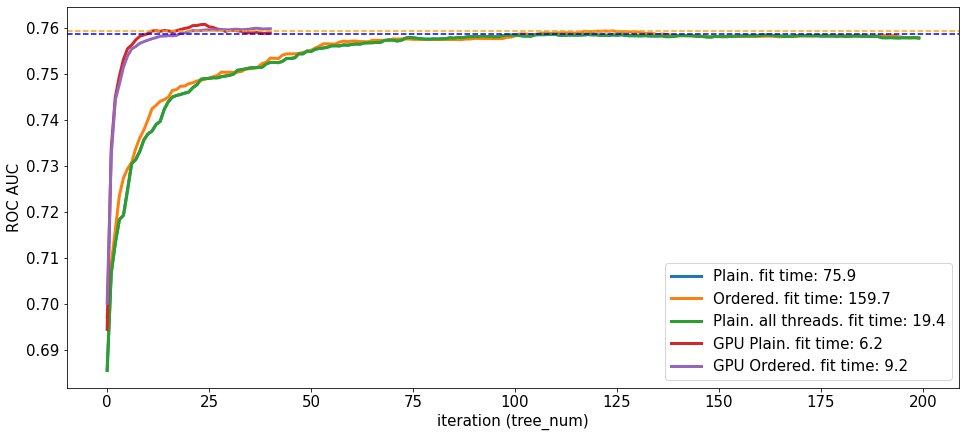

In [44]:
%%time

from local_manipulations import *

study_cb = plot_cb_ordered(X_tr, y_tr, X_val, y_val, n_trials=200, cat_features=cat_features)

**small train 10k**

Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU


CPU times: total: 50min 52s
Wall time: 50min 23s


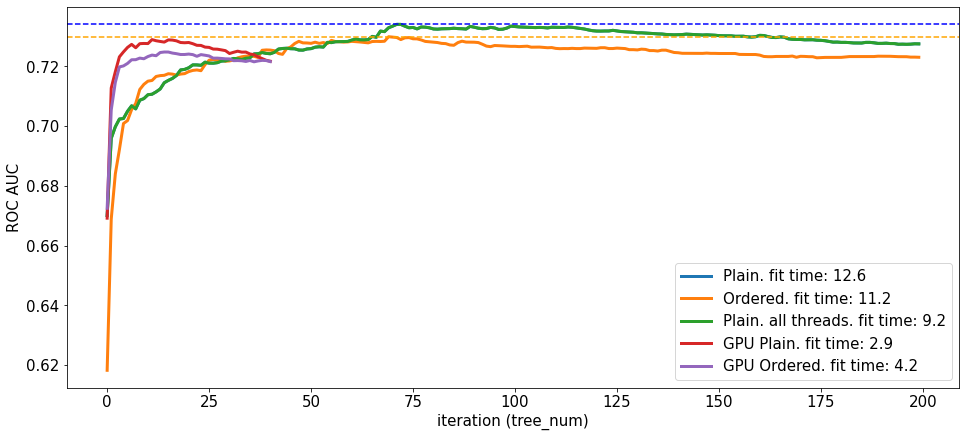

In [52]:
%%time

tr_idx = np.random.choice(X_tr.shape[0], replace=False, size=10_000)

X_tr_10k, y_tr_10k = X_tr.iloc[tr_idx], y_tr.iloc[tr_idx]

study_cb_10k = plot_cb_ordered(X_tr_10k, y_tr_10k, X_val, y_val, n_trials=200, cat_features=cat_features)

**Вывод:** ordered mode можно попробовать на маленьких задачах, если у вас ожидается сильный prediction shift / больше ничего не заходит. Но лучше на GPU :)

### `3.5 categories`

[дока](https://catboost.ai/en/docs/references/training-parameters/ctr)

Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.


CPU times: total: 3min 33s
Wall time: 52.3 s


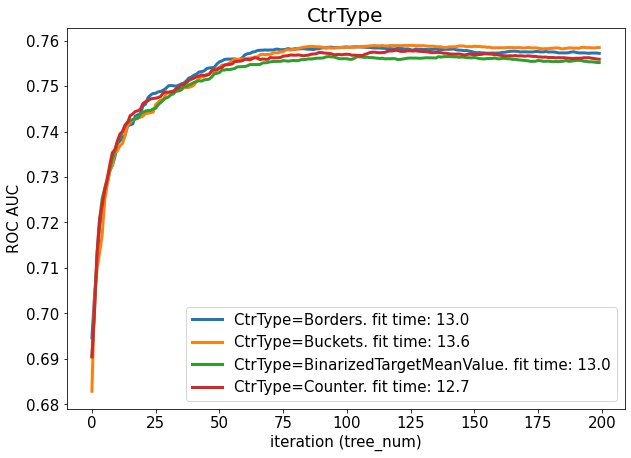

In [47]:
%%time

from local_manipulations import *

plot_cb_ctr(study_cb, X_tr, y_tr, X_val, y_val, cat_features=cat_features)

### `3.6 langevin`

In [53]:
%%time

params = {
    'eta': 0.2,
    'thread_count': 16,
    
    'langevin': [True, False],
#     'diffusion_temperature': 10_000,
}

study = start_cb_random_search(params, X_tr, y_tr,
                               X_val, y_val, n_trials=13, cat_features=cat_features)

fig = plot_slice(study, target=lambda trial: trial.values[0], target_name='ROC AUC score')
fig.update_layout(height=400, width=600)

CPU times: total: 8min 1s
Wall time: 1min 52s


In [54]:
fig = plot_slice(study, target=lambda trial: trial.values[1], target_name='time, sec')
fig.update_layout(height=400, width=600)

### `3.6 sample_gaussian`

## 4. LightGBM vs. CatBoost (speed)

In [50]:
N = int(1e7)
n_features = 120
X_dummy = np.random.randn(N, n_features).astype(np.float32)
y_dummy = np.random.randint(0, 2, N)

100%|███████████████████████████████████████████████| 6/6 [01:06<00:00, 11.06s/it]


CPU times: total: 14min 13s
Wall time: 1min 6s


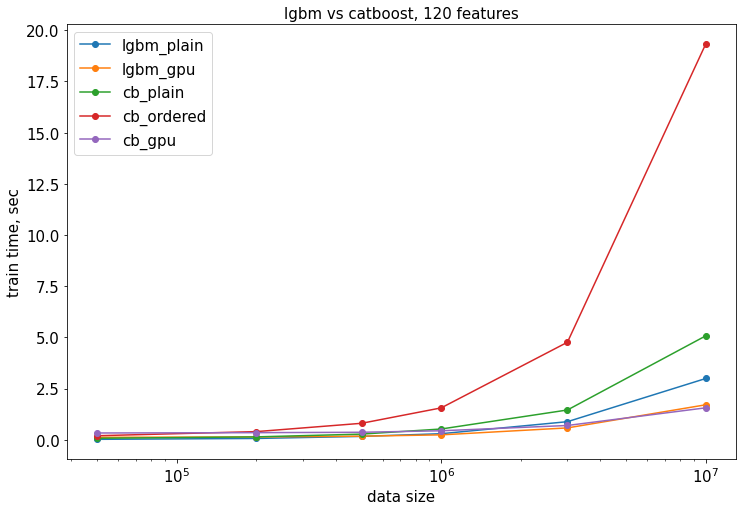

In [51]:
%%time

from local_manipulations import *

plot_lgb_vs_catboost(X_dummy, y_dummy)